In [7]:
# Brain Tumor Detection: Data Exploration
# ======================================
# This notebook explores the Brain MRI dataset for tumor detection

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Add project root to path
sys.path.append('..')
from src.data_processing.loader import get_class_weights

# Set plotting style
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
%matplotlib inline

# Data paths
DATA_DIR = '../data/processed'

C:\Users\jessi\AppData\Local\Temp\ipykernel_34336\791697576.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Dataset Overview

Dataset metadata:
   split     label  count
0  train     tumor     61
1  train  no_tumor     64
2    val     tumor     13
3    val  no_tumor     14
4   test     tumor     13
5   test  no_tumor     14


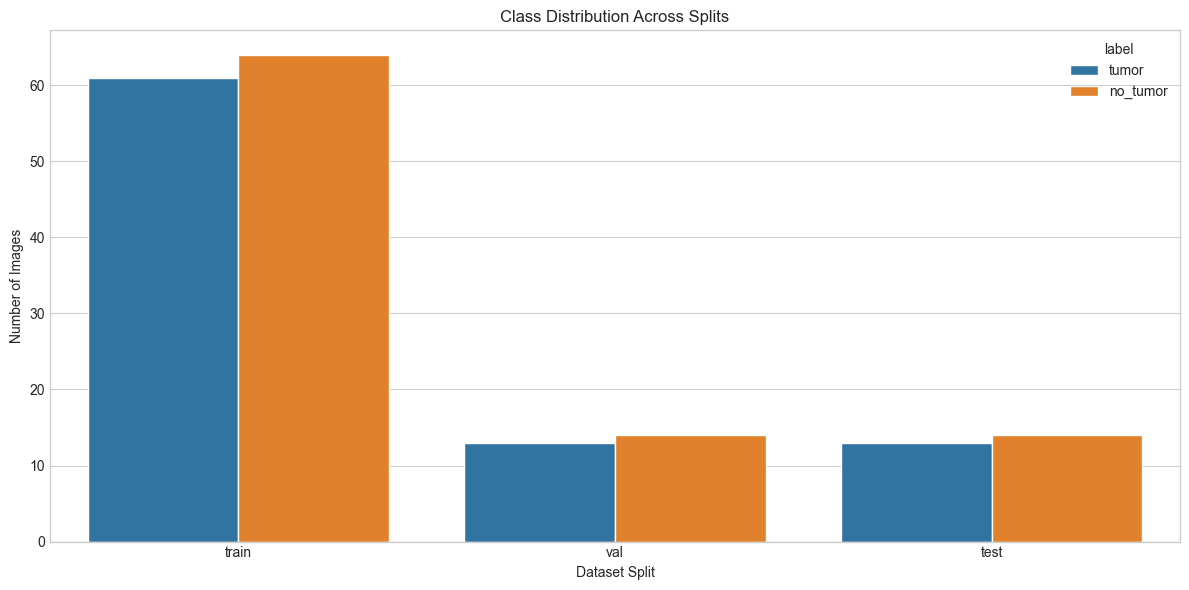


Class balance:
label
no_tumor    92
tumor       87
Name: count, dtype: int64
Tumor percentage: 48.60%


In [8]:
# Load metadata
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
print(f"Dataset metadata:\n{metadata}")

# Display class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='split', y='count', hue='label', data=metadata)
plt.title('Class Distribution Across Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate class balance
class_totals = metadata.groupby('label')['count'].sum()
print(f"\nClass balance:\n{class_totals}")
print(f"Tumor percentage: {class_totals['tumor']/class_totals.sum()*100:.2f}%")

# Image Visualization

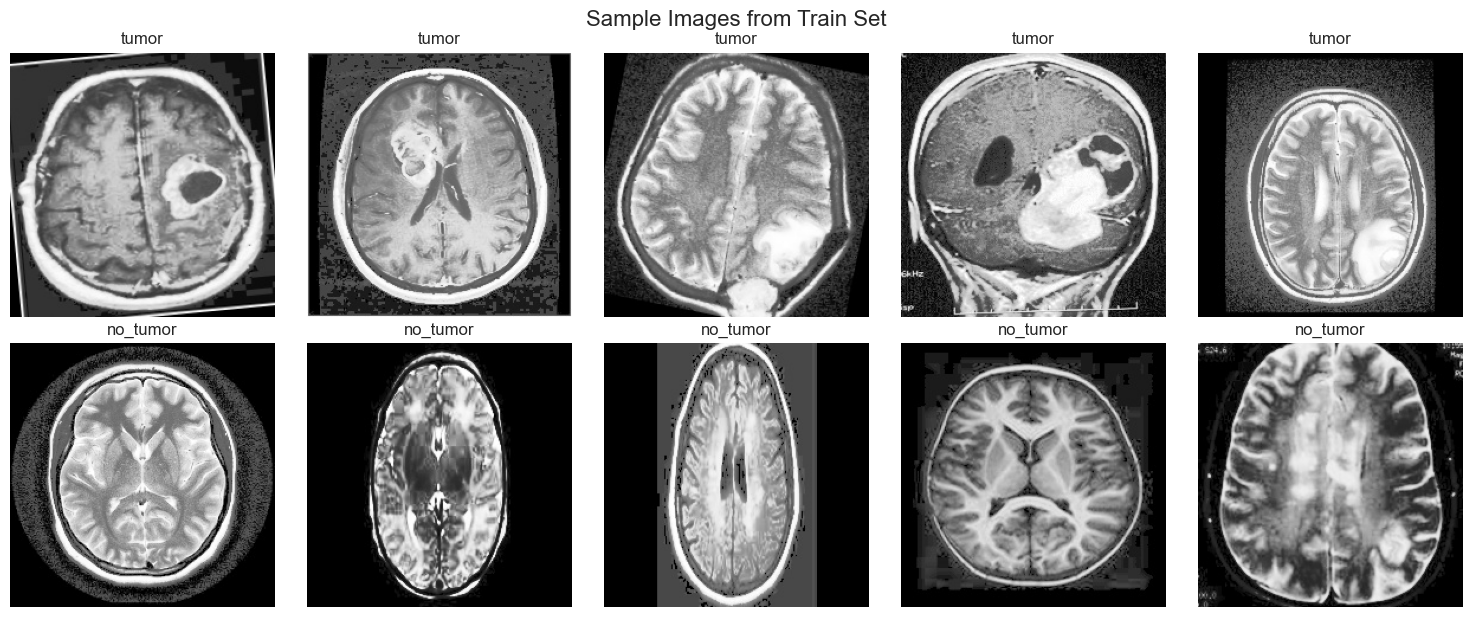

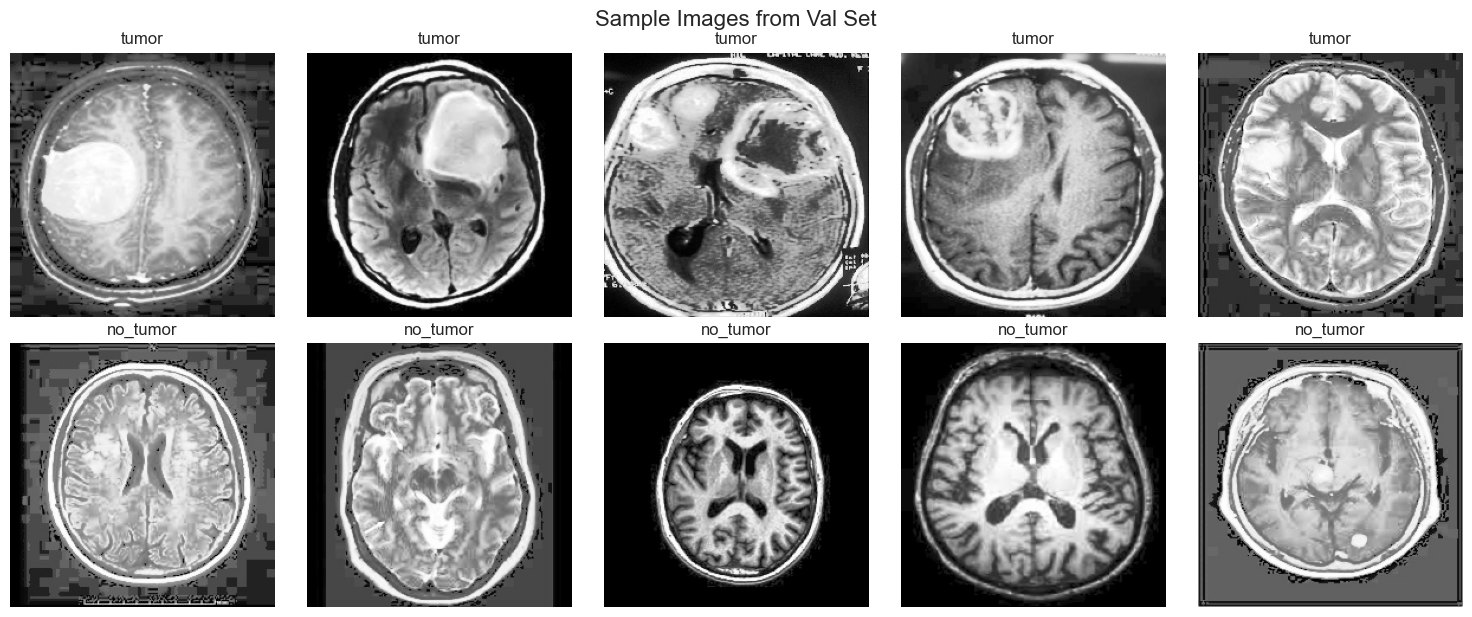

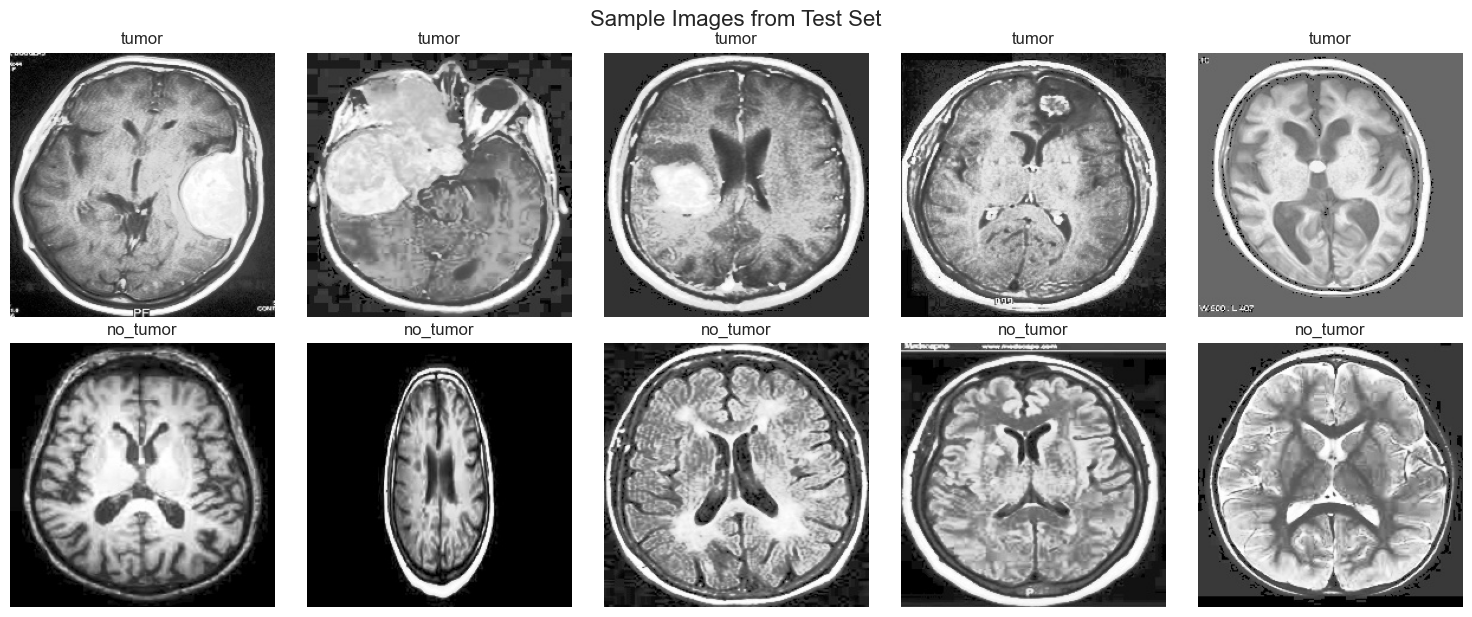

In [9]:
# Function to load and display images
def display_sample_images(split='train', num_samples=5):
    """Display sample images from each class in the specified split"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i, label in enumerate(['tumor', 'no_tumor']):
        img_dir = os.path.join(DATA_DIR, split, label)
        img_files = os.listdir(img_dir)[:num_samples]
        
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(img_dir, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{label}")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Sample Images from {split.capitalize()} Set', y=1.02, fontsize=16)
    plt.show()

# Display samples from each split
for split in ['train', 'val', 'test']:
    display_sample_images(split)

# Image Properties Analysis

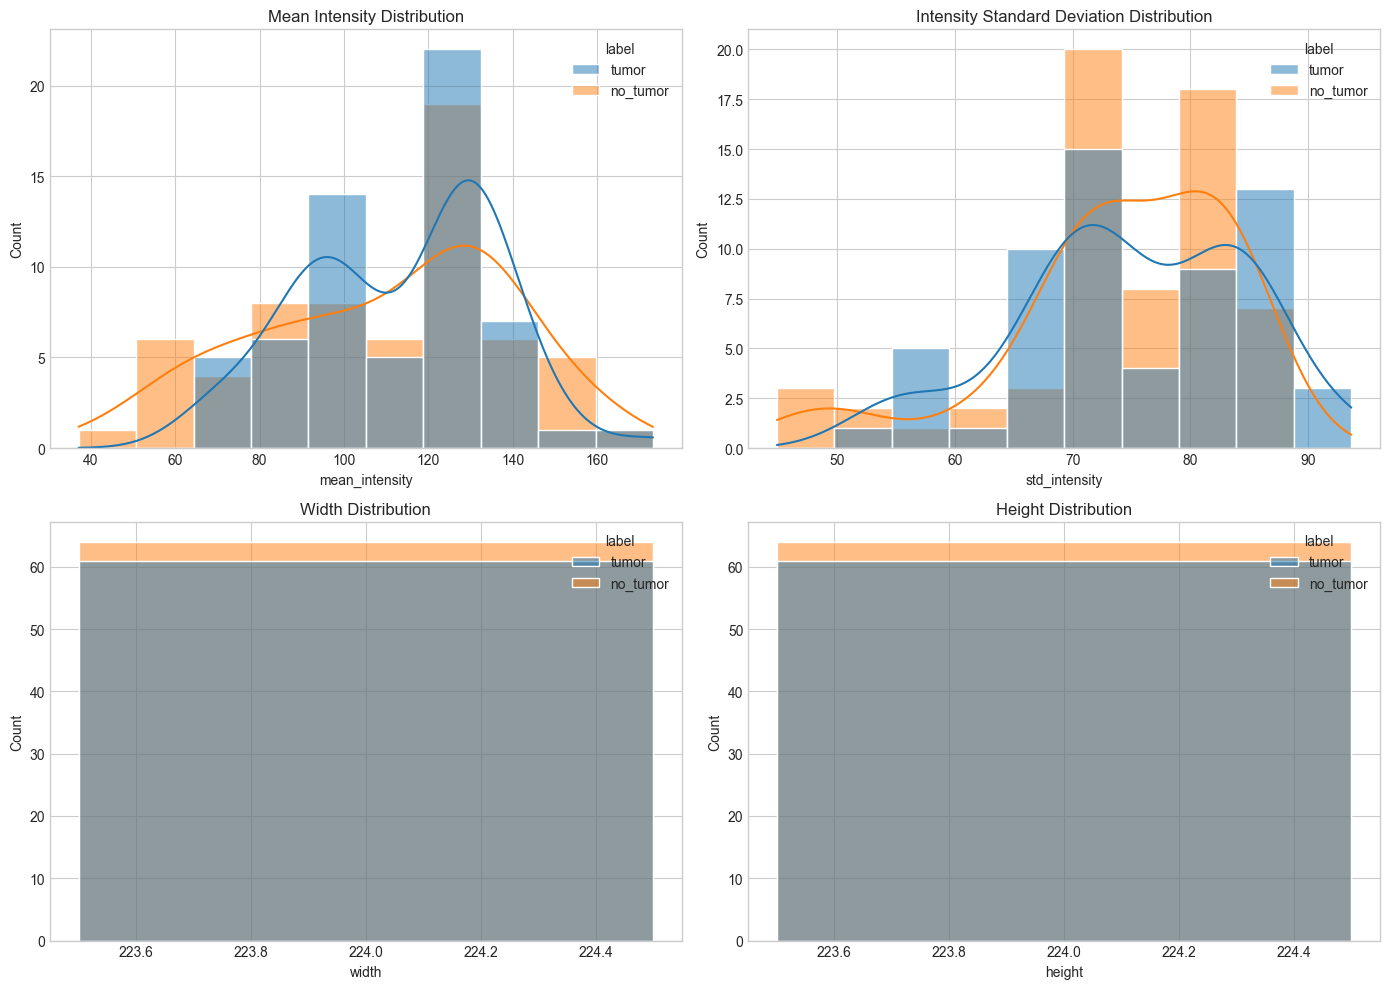

Summary statistics for tumor images:
       width  height  mean_intensity  std_intensity
count   61.0    61.0       61.000000      61.000000
mean   224.0   224.0      113.561511      75.069123
std      0.0     0.0       22.895402       9.639514
min    224.0   224.0       67.968033      53.037688
25%    224.0   224.0       95.632713      69.272087
50%    224.0   224.0      121.908183      73.195334
75%    224.0   224.0      130.323103      84.131477
max    224.0   224.0      173.143814      93.655690

Summary statistics for non-tumor images:
       width  height  mean_intensity  std_intensity
count   64.0    64.0       64.000000      64.000000
mean   224.0   224.0      109.377956      74.040871
std      0.0     0.0       30.356391       9.818142
min    224.0   224.0       37.177794      44.892041
25%    224.0   224.0       85.701291      70.175142
50%    224.0   224.0      115.110182      74.744683
75%    224.0   224.0      130.704311      81.712888
max    224.0   224.0      165.334104 

In [11]:
# Analyze image properties across the dataset
def analyze_image_properties(split='train', num_samples=100):
    """Analyze image properties such as dimensions, intensity, etc."""
    properties = {
        'width': [],
        'height': [],
        'mean_intensity': [],
        'std_intensity': [],
        'label': []
    }
    
    for label in ['tumor', 'no_tumor']:
        img_dir = os.path.join(DATA_DIR, split, label)
        img_files = os.listdir(img_dir)
        
        # Sample images if there are too many
        sample_files = img_files[:min(num_samples, len(img_files))]
        
        for img_file in sample_files:
            img_path = os.path.join(img_dir, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Get properties
            h, w, _ = img.shape
            mean_intensity = np.mean(img)
            std_intensity = np.std(img)
            
            # Add to lists
            properties['width'].append(w)
            properties['height'].append(h)
            properties['mean_intensity'].append(mean_intensity)
            properties['std_intensity'].append(std_intensity)
            properties['label'].append(label)
    
    # Convert to DataFrame
    props_df = pd.DataFrame(properties)
    return props_df

# Analyze training set
train_props = analyze_image_properties('train')

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean intensity distribution
sns.histplot(data=train_props, x='mean_intensity', hue='label', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Mean Intensity Distribution')

# Std intensity distribution
sns.histplot(data=train_props, x='std_intensity', hue='label', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Intensity Standard Deviation Distribution')

# Width distribution
sns.histplot(data=train_props, x='width', hue='label', kde=False, ax=axes[1, 0])
axes[1, 0].set_title('Width Distribution')

# Height distribution
sns.histplot(data=train_props, x='height', hue='label', kde=False, ax=axes[1, 1])
axes[1, 1].set_title('Height Distribution')

plt.tight_layout()
plt.show()

# Display summary statistics
print("Summary statistics for tumor images:")
print(train_props[train_props['label'] == 'tumor'].describe())
print("\nSummary statistics for non-tumor images:")
print(train_props[train_props['label'] == 'no_tumor'].describe())

# Pixel Intensity Analysis

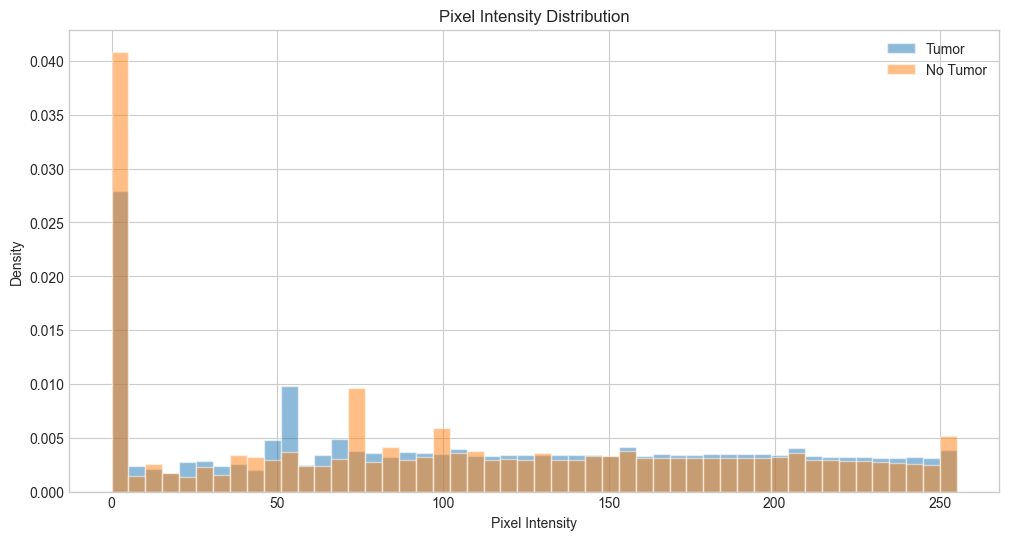

In [12]:
# Analyze pixel intensity distributions
def analyze_pixel_intensities(split='train', num_samples=20):
    """Analyze pixel intensity distributions for each class"""
    tumor_intensities = []
    no_tumor_intensities = []
    
    # Sample tumor images
    tumor_dir = os.path.join(DATA_DIR, split, 'tumor')
    tumor_files = os.listdir(tumor_dir)[:num_samples]
    
    for img_file in tumor_files:
        img_path = os.path.join(tumor_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        tumor_intensities.extend(img.flatten())
    
    # Sample non-tumor images
    no_tumor_dir = os.path.join(DATA_DIR, split, 'no_tumor')
    no_tumor_files = os.listdir(no_tumor_dir)[:num_samples]
    
    for img_file in no_tumor_files:
        img_path = os.path.join(no_tumor_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        no_tumor_intensities.extend(img.flatten())
    
    # Plot histograms
    plt.figure(figsize=(12, 6))
    
    plt.hist(tumor_intensities, bins=50, alpha=0.5, density=True, label='Tumor')
    plt.hist(no_tumor_intensities, bins=50, alpha=0.5, density=True, label='No Tumor')
    
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Analyze pixel intensities
analyze_pixel_intensities()

# Effect of Data Preprocessing

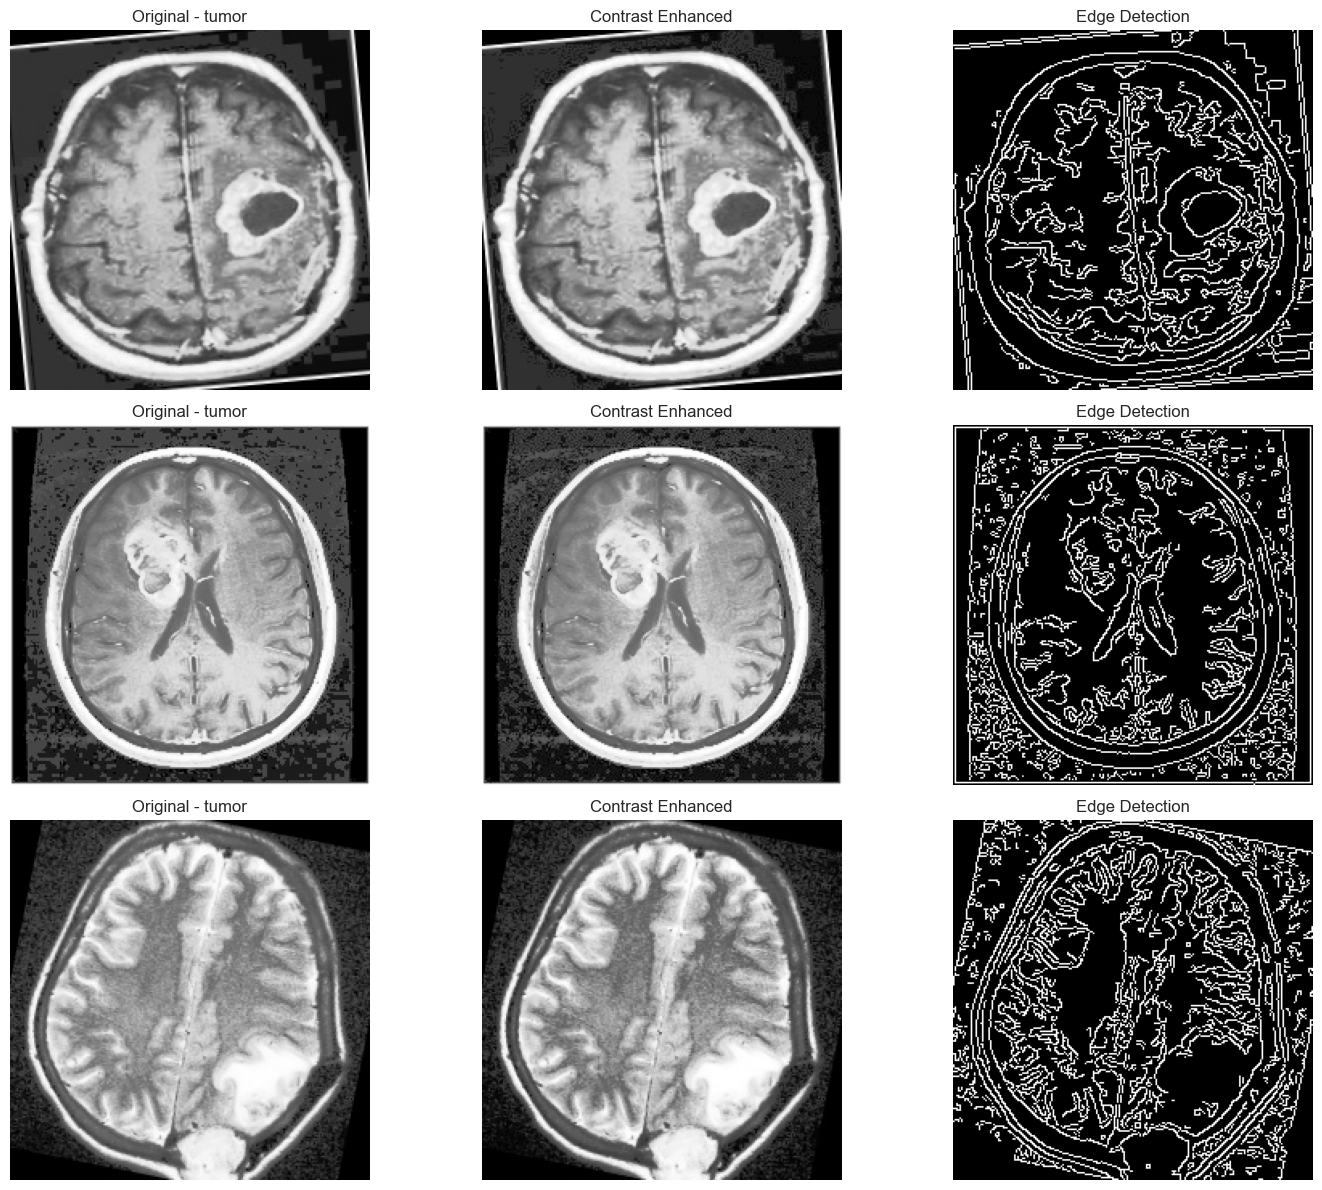

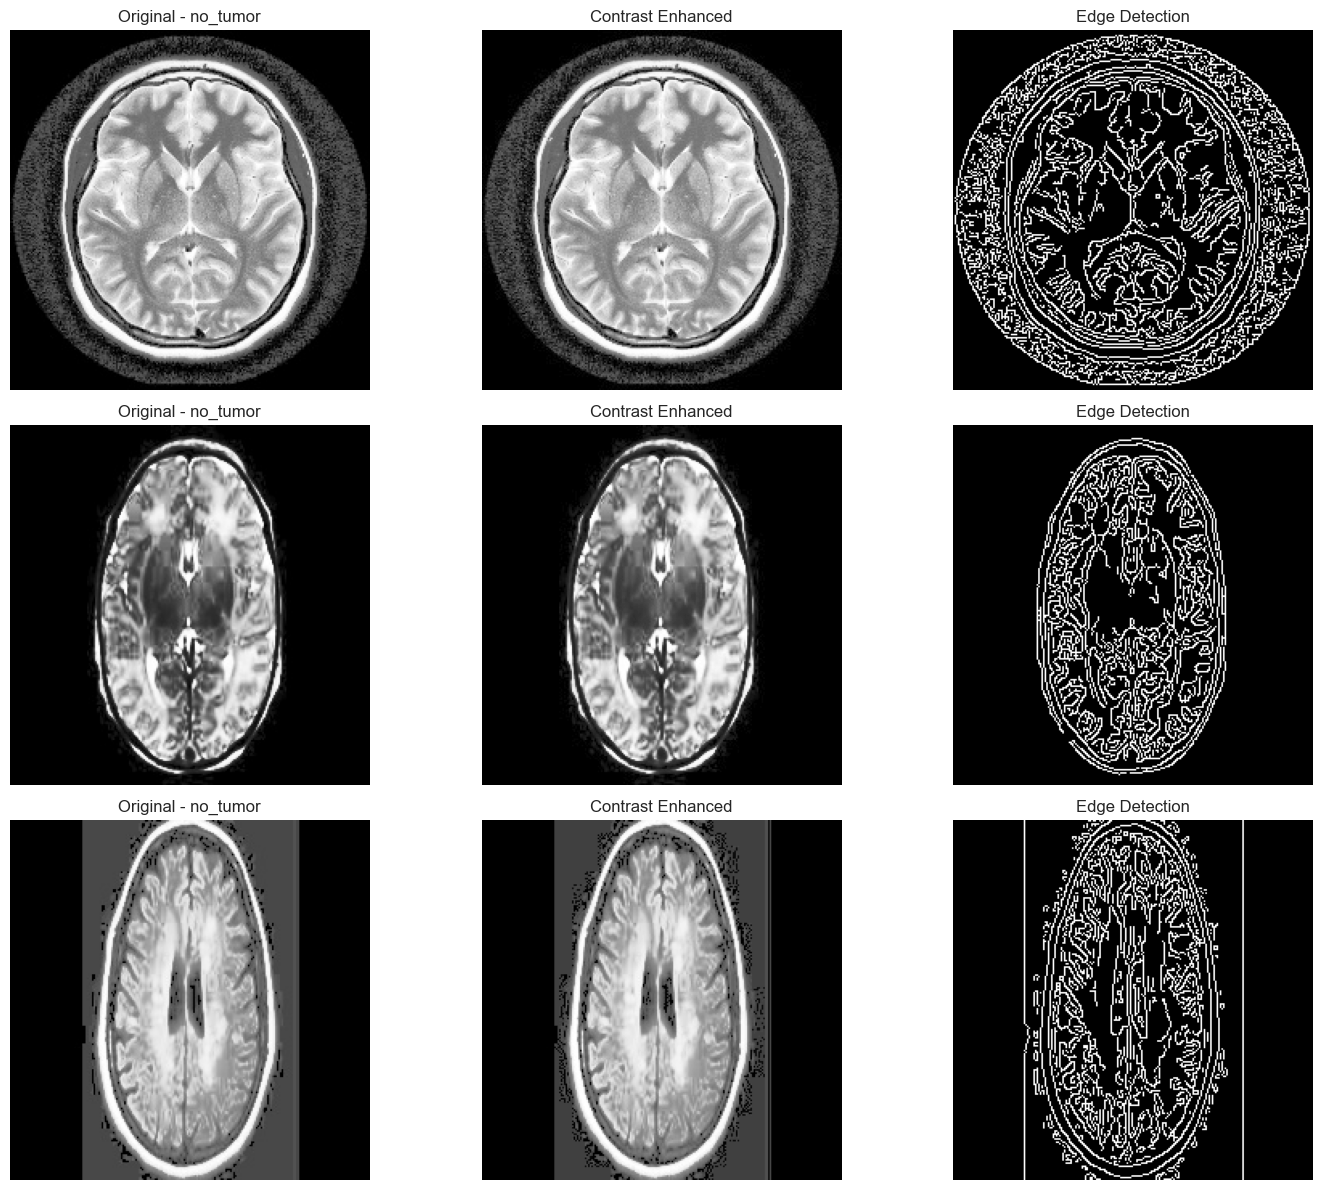

In [13]:
# Demonstrate the effect of preprocessing on images
def show_preprocessing_effects(num_samples=3):
    """Show original vs preprocessed images"""
    # Get sample images from tumor and no_tumor classes
    for label in ['tumor', 'no_tumor']:
        plt.figure(figsize=(15, 4*num_samples))
        
        img_dir = os.path.join(DATA_DIR, 'train', label)
        img_files = os.listdir(img_dir)[:num_samples]
        
        for i, img_file in enumerate(img_files):
            img_path = os.path.join(img_dir, img_file)
            
            # Load original image (before preprocessing)
            # Note: This is a simplification; we're actually loading the already preprocessed image
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Apply histogram equalization to show contrast enhancement
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_eq = cv2.equalizeHist(img_gray)
            
            # Apply edge detection to highlight features
            img_edges = cv2.Canny(img_gray, 100, 200)
            
            # Display the images
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(img_rgb)
            plt.title(f"Original - {label}")
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(img_eq, cmap='gray')
            plt.title(f"Contrast Enhanced")
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(img_edges, cmap='gray')
            plt.title(f"Edge Detection")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Show preprocessing effects
show_preprocessing_effects()

# Class Weight Calculation

Class weights for model training:
{0: 0.9765625, 1: 1.0245901639344261}


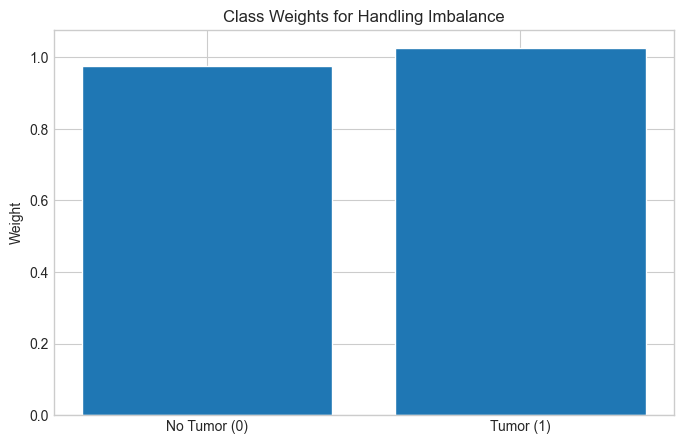

In [14]:
# Calculate class weights for handling imbalance
class_weights = get_class_weights(DATA_DIR)
print("Class weights for model training:")
print(class_weights)

# Visualize class weights
plt.figure(figsize=(8, 5))
plt.bar(["No Tumor (0)", "Tumor (1)"], [class_weights[0], class_weights[1]])
plt.title('Class Weights for Handling Imbalance')
plt.ylabel('Weight')
plt.show()

# Conclusion

In [15]:
# Summarize findings
print("Dataset Exploration Summary:")
print("--------------------------")
print(f"Total images: {metadata['count'].sum()}")
print(f"Number of tumor images: {class_totals['tumor']}")
print(f"Number of non-tumor images: {class_totals['no_tumor']}")
print(f"Class balance: {class_totals['tumor']/class_totals.sum()*100:.2f}% tumor vs {class_totals['no_tumor']/class_totals.sum()*100:.2f}% non-tumor")
print("\nPreprocessed image size: 224x224 pixels")
print("Data augmentation applied to training set")
print("Preprocessing includes: resizing, normalization, contrast enhancement")

# Key observations and next steps
print("\nKey Observations:")
print("1. [Fill in after running the analysis]")
print("2. [Fill in after running the analysis]")
print("3. [Fill in after running the analysis]")

print("\nNext Steps:")
print("1. Implement and train supervised learning models")
print("2. Explore unsupervised approaches for feature extraction")
print("3. Implement state-of-the-art architectures")

Dataset Exploration Summary:
--------------------------
Total images: 179
Number of tumor images: 87
Number of non-tumor images: 92
Class balance: 48.60% tumor vs 51.40% non-tumor

Preprocessed image size: 224x224 pixels
Data augmentation applied to training set
Preprocessing includes: resizing, normalization, contrast enhancement

Key Observations:
1. [Fill in after running the analysis]
2. [Fill in after running the analysis]
3. [Fill in after running the analysis]

Next Steps:
1. Implement and train supervised learning models
2. Explore unsupervised approaches for feature extraction
3. Implement state-of-the-art architectures
